In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular

import tornadox
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import pof
from pof.main import (
    make_continuous_models,
    discretize_transitions,
    get_constant_initial_trajectory,
    linearize_observation_model,
    get_x0,
)
from pof.ieks import filtsmooth, smoothing
from pof.solve import solve_diffrax
from pof.utils import tria

First define the IVP and compute a reference solution with diffrax

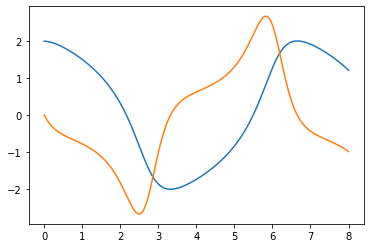

In [3]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0, tmax=8)
ts_true, ys_true, sol_true = solve_diffrax(ivp, rtol=1e-10, atol=1e-10)
plt.plot(ts_true, ys_true)

We now want to solve it with a time-parallel IEKS.

# Solving IVPs with the IEKS
We already did this in previous notebooks, but now the structure is a bit different: first create a continuous model, then discretize it, and then run a linear filter/smoother on that.

In [4]:
order = 5
dt = 1e-1

In [5]:
# define the time grid
ts = jnp.arange(0, ivp.tmax + dt, dt)
# make a constant initial trajectory from y0
traj = get_constant_initial_trajectory(ivp.y0, order, len(ts))

# make the continuous transition and observation models
iwp, om = make_continuous_models(ivp, order)
E0 = pof.transitions.projection_matrix(iwp, 0)

# make the discrete transition and observation model
dtm = discretize_transitions(iwp, ts)
dom = linearize_observation_model(om, traj[1:])

# for the initial guess, use Taylor-mode autodiff as usual via tornadox
x0 = get_x0(ivp, order)

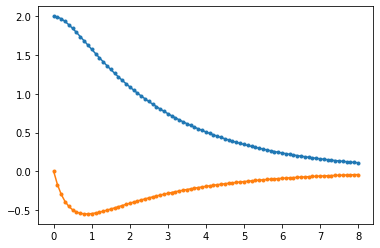

In [6]:
out = pof.ieks.linear_noiseless_filtering(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts, ys, marker=".")

Now let's see what happens if we iterate filter and smoother for a while. Note that we only have to re-linearize the observation model; the discretized transition model stays the same.

  0%|          | 0/10 [00:00<?, ?it/s]

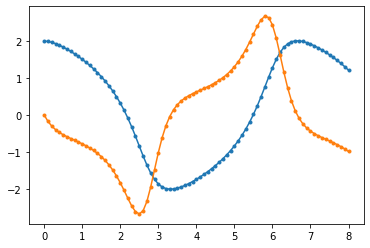

In [7]:
out = filtsmooth(x0, dtm, dom)
ITERS = 10
for i in trange(ITERS):
    dom = linearize_observation_model(om, out.mean[1:])
    out = filtsmooth(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts, ys, marker=".")

That looks pretty good!

But is it? Let's check the actual errors:

In [8]:
_ts, _ys, _ = solve_diffrax(ivp, dt=dt)

err_final_dp5 = ys_true[-1] - _ys[-1]
err_final_ieks = ys_true[-1] - (E0 @ out.mean[-1])
(err_final_dp5, err_final_ieks)

(DeviceArray([2.79914521e-06, 2.05263228e-06], dtype=float64, weak_type=True),
 DeviceArray([ 4.13375585e-08, -2.70852158e-07], dtype=float64))

That's pretty good! 

But there is one thing though: We actually used 10 times more vector field evaluations. If we compare with a solver with denser steps, things look different:

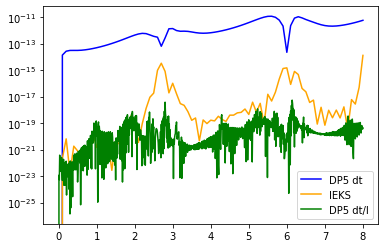

In [9]:
_ts2, _ys2, _ = solve_diffrax(ivp, dt=dt/ITERS)

plt.plot(_ts, (jax.vmap(sol_true.evaluate)(_ts) - _ys).mean(axis=1)**2, color="blue", label="DP5 dt")
plt.plot(ts, (jax.vmap(sol_true.evaluate)(ts) - ys).mean(axis=1)**2, color="orange", label="IEKS")
plt.plot(_ts2, (jax.vmap(sol_true.evaluate)(_ts2) - _ys2).mean(axis=1)**2, color="green", label="DP5 dt/I")
plt.yscale("log")
plt.legend()

But still fine :)

# Uncertainties

One thing I didn't really do so far is to look at the uncertainties. So let's do that!

In [10]:
@jax.jit
def get_std(cholP, E0):
    cholP0 = E0 @ cholP
    P0 = cholP0 @ cholP0.T
    return jnp.sqrt(jnp.diagonal(P0))

In [11]:
stds = jax.vmap(get_std, in_axes=[0, None])(out.chol, E0)

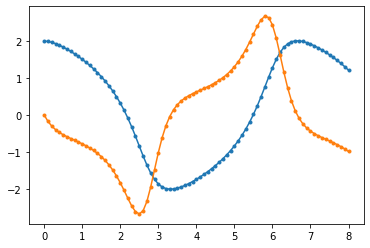

In [12]:
plt.plot(ts, ys, marker=".")
for i in range(ys.shape[1]):
    plt.fill_between(ts, ys[:, i] - 3 * stds[:, i], ys[:, i] + 3 * stds[:, i], alpha=0.2)

As usual, we don't see anything. Let's plot errors:

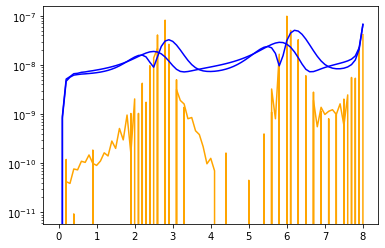

In [13]:
plt.plot(ts, (jax.vmap(sol_true.evaluate)(ts) - ys), color="orange", label="IEKS")
plt.plot(ts, 3 * stds, color="blue")
plt.yscale("log")

Looks reasonable! 

....I'm stupid actually. This is completely uncalibrated. So basically, it's arbitrary.

## How to calibrate uncertainties

With the prediction-error-decomposition.

In [14]:
@jax.jit
def whiten(m, cholP):
    return solve_triangular(cholP, m)

@jax.jit
def get_whitened_residual(F, cholQ, H, c, m_t_1, cholP_t_1):
    predicted_mean = F @ m_t_1
    predicted_chol = tria(jnp.concatenate([F @ cholP_t_1, cholQ], axis=1))
    obs_mean = H @ predicted_mean + c
    obs_chol = tria(H @ predicted_chol)
    return whiten(obs_mean, obs_chol)

@jax.jit
def get_sigma_estimate(filtered_states, discrete_transitions, discrete_observations):
    N, d = discrete_observations.b.shape
    F, cholQ = discrete_transitions
    H, b = discrete_observations
    m, cholP = filtered_states
    whitened_residuals = jax.vmap(get_whitened_residual)(
        F, cholQ, H, b, m[:-1], cholP[:-1]
    )
    chisquares = jax.vmap(lambda r: jnp.dot(r, r))(whitened_residuals)
    return jnp.sqrt(jnp.sum(chisquares) / d / (N + 2))

We have to look at the filtering distribution again.

In [15]:
out = pof.ieks.linear_noiseless_filtering(x0, dtm, dom)
sigma_est = get_sigma_estimate(out, dtm, dom)
sigma_est

DeviceArray(2296.65672868, dtype=float64)

That is large! So, we have to make the uncertainties even larger???

Let's look at the filter and smoother estimates and their errors and error estimates

In [16]:
ys_filt = jnp.dot(E0, out.mean.T).T
stds_filt = jax.vmap(get_std, in_axes=[0, None])(out.chol, E0) * sigma_est

smoothed = smoothing(dtm, out)
ys_smooth = jnp.dot(E0, smoothed.mean.T).T
stds_smooth = jax.vmap(get_std, in_axes=[0, None])(smoothed.chol, E0) * sigma_est

import bqplot
import bqplot.pyplot as bplt
fig = bplt.figure(scales={'y': bqplot.scales.LogScale()})
bplt.plot(ts, jnp.abs(jax.vmap(sol_true.evaluate)(ts) - ys_filt).T,
          color=["Filter Error", "Filter Error"])
bplt.plot(ts, 3 * stds_filt.T, label="Filter 3SD", 
          color=["Filter 3SD", "Filter 3SD"])
bplt.plot(ts, jnp.abs(jax.vmap(sol_true.evaluate)(ts) - ys_smooth).T, 
          color=["Smoother Error", "Smoother Error"])
bplt.plot(ts, 3 * stds_smooth.T,
          color=["Smoother 3SD", "Smoother 3SD"])
bplt.ylim(1e-12, 1e-3)
fig

Figure(axes=[ColorAxis(scale=OrdinalColorScale()), Axis(scale=LinearScale()), Axis(orientation='vertical', sca…

So, it seems the calibration works, in the sense that the _filtering_ distribution is much more calibrated. 
However, the _smoothing_ posterior is very underconfident; which is at least better than being overconfident.